In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# !pip install -U git+https://github.com/qubvel/efficientnet

In [3]:
__file__ = 'EfficientNet-B5-9.7.3-0123'
__version__ = 'v11'
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
fold = 0

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time
import efficientnet.keras as efn 

Using TensorFlow backend.


In [5]:
path_data_train = '../tmp/train_data_aug/'
path_data_valid = '../garbage_classify/train_data_v2/'
batch_size = 64
img_size = 456
img_width = img_size
img_height = img_size
random_seed = 201908

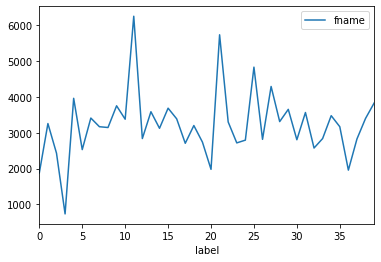

In [6]:
labels_train = pd.read_csv(f'../tmp/labels_train_aug_{__version__}_fold{fold}.csv')
labels_valid = pd.read_csv(f'../tmp/labels_valid_{__version__}_fold{fold}.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [7]:
special = [True, False, False, False, False, False, False, False,  True,
             True, False, False, False, False,  True,  True,  True, False,
             False, False, False, False,  True,  True, False, False, False,
             False, False, False, False,  True,  True,  True, False, False,
             True, False, False, False]

In [8]:
n_samples = 1000

lbs = []
for lb in range(40):
    lbs_df = labels_train[labels_train.label==lb]
    if lbs_df.shape[0] > n_samples:
        if special[lb]:
            lbs_df = lbs_df.sample(n=n_samples,random_state=random_seed)
        else:
            lbs_df = lbs_df.sample(n=n_samples//2,random_state=random_seed)
    lbs.append(lbs_df)
lbs_train = pd.concat(lbs)

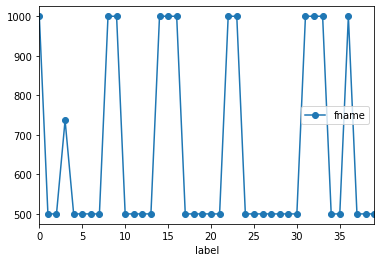

In [9]:
lbs_train.groupby(by='label').count().plot(style='-o')

In [10]:
# labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
lbs_train.label = lbs_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

# labels_train.label = labels_train.label.apply(int)
# labels_valid.label = labels_valid.label.apply(int)

In [11]:
ig = ImageDataGenerator(preprocessing_function=efn.preprocess_input,
                        horizontal_flip=True,
                        vertical_flip=True)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    interpolation='lanczos',
    seed=random_seed)

train_g = ig.flow_from_dataframe(lbs_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(labels_valid[:-(labels_valid.shape[0] % batch_size)], path_data_valid, shuffle=False, **params_g)

Found 26237 validated image filenames belonging to 40 classes.
Found 2944 validated image filenames belonging to 40 classes.


In [12]:
m = ('../tmp/model_EfficientNet-B5-9.5.14-2.json','../tmp/ckpt-EfficientNet-B5-9.5.14-2-Epoch_063-acc_0.99573-val_acc_0.94769.h5')
with open(m[0], 'r') as f:
    model = model_from_json(f.read())
    model.load_weights(m[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
from keras.utils import multi_gpu_model
model = multi_gpu_model(model,gpus=4)

with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [14]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc',verbose=1)

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=1e-5,verbose=1)

csv_logger = CSVLogger(f'../tmp/training_{__file__}.log',append=True)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop,reduce_lr,csv_logger],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 13/409 [..............................] - ETA: 49:18 - loss: 0.0886 - acc: 0.9712

In [ ]:
!ls